In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from statistics import mean
from scipy.optimize import curve_fit

from LUT_functions import pixel_registration, create_LUT_df
import scipy


In [2]:
#choose filepath to desired data
path ='C:\\Users\\khart\Documents\\IRCSP2_data\calibration_data\LUT\\2221\\'
cal_file1 =  "C:\\Users\\khart\Documents\\IRCSP2_data\calibration_files\cam1pixel.h5"
cal_file2 = "C:\\Users\\khart\Documents\\IRCSP2_data\calibration_files\cam2pixel.h5"

In [7]:
#will create a df and print the names of the keys in the original hdf5 file
df1 = create_LUT_df(path,'cam1_20.0c.h5')
df2 = create_LUT_df(path,'cam2_20.0c.h5')
df2

,images1,temp1
0,"[[23841, 23854, 23853, 23847, 23828, 23841, 23...",27.7
1,"[[23758, 23771, 23771, 23776, 23765, 23769, 23...",27.8
2,"[[23873, 23861, 23866, 23860, 23860, 23868, 23...",27.9
3,"[[23788, 23766, 23801, 23794, 23789, 23788, 23...",28.0
4,"[[23729, 23720, 23732, 23728, 23744, 23722, 23...",28.1
...,...,...
95,"[[22674, 22636, 22654, 22663, 22663, 22667, 22...",33.3
96,"[[22658, 22653, 22664, 22664, 22645, 22658, 22...",33.3
97,"[[22651, 22649, 22662, 22660, 22638, 22665, 22...",33.3
98,"[[22652, 22639, 22660, 22645, 22641, 22657, 22...",33.4


In [8]:
waves= np.linspace(7,12,61)
temps = [20,21,22,23]

In [11]:
#apply pixel registration and NUC to full dataset

ymin1 = 105; ymax1 = 140;
ymin2 = 130; ymax2 = 165;

mean_ims1 =[]
mean_ims2 =[]
std_ims1  =[]
std_ims2  =[]

for i in temps:
    #will create a df and print the names of the keys in the original hdf5 file
    df1 = create_LUT_df(path,'cam1_'+str(i)+'.0c.h5')
    df2 = create_LUT_df(path,'cam2_'+str(i)+'.0c.h5')
    
    corrected_images1= []
    corrected_images2= []

    for i in range(len(df1)):
        c = pixel_registration(df1['images1'][i],cal_file1,waves,ymin1,ymax1)
        corrected_images1.append(c)

    for i in range(len(df2)):
        c = pixel_registration(df2['images1'][i],cal_file2,waves,ymin2,ymax2)
        corrected_images2.append(c)

    mean_ims1.append(np.mean(corrected_images1,axis = 0))
    mean_ims2.append(np.mean(corrected_images2,axis = 0))

    std_ims1.append(np.std(corrected_images1,axis = 0))
    std_ims2.append(np.std(corrected_images2,axis = 0))

In [12]:
d = {'BB_temps': temps, 'ims1': list(mean_ims1),'s1': list(std_ims1), 'ims2':list(mean_ims2),'s2': list(std_ims2)}

In [13]:
df = pd.DataFrame.from_dict(d, orient='index')
df = df.transpose()

In [14]:
def finv(y,A,B):
    return ((y-B)/A)**0.5


Text(0.5, 1.0, 'Target Temp = 20$^\\circ C$')

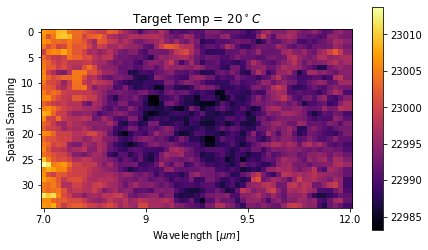

In [15]:
cmin = np.min(list(df['ims1'])); cmax=np.max(list(df['ims2']))

j = 0;
plt.matshow(df['ims2'][j],cmap = 'inferno' )
plt.colorbar()
plt.ylabel('Spatial Sampling')
plt.xlabel('Wavelength [$\mu m$]')
plt.ax = plt.gca()
plt.ax.xaxis.set_ticks_position('bottom')
plt.xticks([0, 20, 40,60], [waves[0],round(waves[20]),waves[30],waves[60]])
plt.title('Target Temp = ' + str(temps[j])+ '$^\circ C$')
#plt.clim(cmin,cmax)

In [16]:
#create sum column
df["totalrad"] = df['ims2']+df['ims1']
df["totalstd"] = (df['s2']**2+df['s1']**2)**0.5

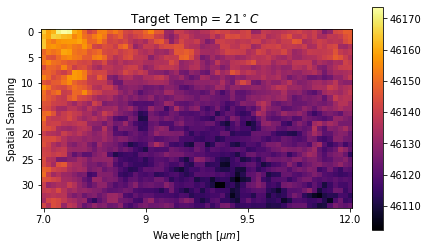

In [17]:
cmin = np.min(list(df['totalrad'])); cmax=np.max(list(df['totalrad']))

j = 1;
plt.matshow(df['totalrad'][j],cmap = 'inferno' )
plt.colorbar()
plt.ylabel('Spatial Sampling')
plt.xlabel('Wavelength [$\mu m$]')
plt.ax = plt.gca()
plt.ax.xaxis.set_ticks_position('bottom')
plt.xticks([0, 20, 40,60], [waves[0],round(waves[20]),waves[30],waves[60]])
plt.title('Target Temp = ' + str(temps[j])+ '$^\circ C$  ')
#plt.clim(cmin,cmax)
plt.show()

In [286]:
# pixel fit 
def f(x, A, B): # this is your 'straight line' y=f(x)
    return A*x**2 + B

def finv(y,A,B):
    return ((y-B)/A)**0.5

#fit over wavelengths with lowest noise
popt, pcov = curve_fit(f, temps, data) # your data x, y to fit

In [318]:
j=0
#attempt retrival
Ts= np.zeros([35,len(waves)])
for w in range(len(waves)):
    for s in range(35):
        data= list(df['totalrad'][j])[s][w]
        A= As[s][w]
        B = Bs[s][w]
        t = finv(data,A,B)
        Ts[s][w] = t

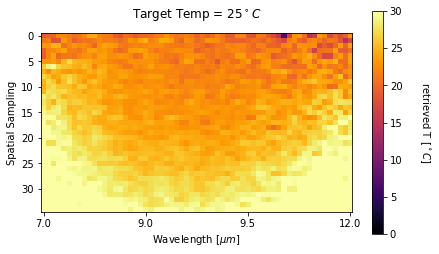

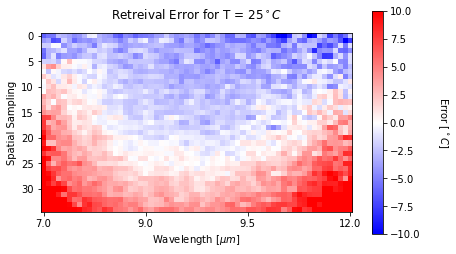

In [319]:

plt.matshow(Ts,cmap = 'inferno' )
cbar = plt.colorbar()
cbar.set_label('retrieved T [$^\circ C$]\n', rotation=-90, va="bottom")
plt.ylabel('Spatial Sampling')
plt.xlabel('Wavelength [$\mu m$]')
plt.ax = plt.gca()
plt.ax.xaxis.set_ticks_position('bottom')
plt.xticks([0, 20, 40,60], [waves[0],round(waves[20]),waves[30],waves[60]])
plt.title('Target Temp = ' + str(temps[j])+ '$^\circ C$')
plt.clim(0,temps[j]+5)
plt.show()

plt.matshow(Ts-temps[j],cmap = 'bwr' )
cbar = plt.colorbar()
cbar.set_label('Error [$^\circ C$]\n', rotation=-90, va="bottom")
plt.ylabel('Spatial Sampling')
plt.xlabel('Wavelength [$\mu m$]')
plt.ax = plt.gca()
plt.ax.xaxis.set_ticks_position('bottom')
plt.xticks([0, 20, 40,60], [waves[0],round(waves[20]),waves[30],waves[60]])
plt.title('Retreival Error for T = ' + str(temps[j])+ '$^\circ C$')
plt.clim(-10,10)
plt.show()

In [296]:
#writetohdf5

#choose filepath to desired data
save_path =  "C://Users//khart//Documents//IRCSP2_data//calibration_files//"
name =  "LUT" 

#create hdf5 file
hf = h5py.File(save_path + name + '.h5', 'w')
hf.create_dataset('/A',  data=As)
hf.create_dataset('/B',  data= Bs)
hf.close()